# <font color='darkblue'>Setup</font> 

## <font color='orange'>Packages</font> 

In [12]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import cmocean

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Functions</font> 

In [2]:
# display progress for long loops -----------------------------------------------------#
def progress_bar(itr,total):
    from time import sleep
    import sys
    sys.stdout.write('\r')
    
    if itr > 0:
        prev = np.round((itr-1)/total*100,2)
    else:
        prev = 0
    
    curr = np.round(itr/total*100,2)
    if (curr != prev):
        # the exact output you're looking for:
#         sys.stdout.write('[%-2s] %d%%' % ('='*int(curr), curr))
        sys.stdout.write('%d%%' % (curr))
        sys.stdout.flush()

# filtering a 2D matrix ---------------------------------------------------------------#
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# put coastlines on map and set xy limits ---------------------------------------------#
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

# create pcolormesh lat/lon vals ------------------------------------------------------#
def pcolor_xy(x,y):
    # extend longitude by 2
    x_extend = np.zeros(x.size+2)
    # fill in internal values
    x_extend[1:-1] = x # fill up with original values
    # fill in extra endpoints
    x_extend[0] = x[0]-np.diff(x)[0]
    x_extend[-1] = x[-1]+np.diff(x)[-1]
    # calculate the midpoints
    x_pcolormesh_midpoints = x_extend[:-1]+0.5*(np.diff(x_extend))

    # extend latitude by 2
    y_extend = np.zeros(y.size+2)
    # fill in internal values
    y_extend[1:-1] = y
    # fill in extra endpoints
    y_extend[0] = y[0]-np.diff(y)[0]
    y_extend[-1] = y[-1]+np.diff(y)[-1]
    # calculate the midpoints
    y_pcolormesh_midpoints = y_extend[:-1]+0.5*(np.diff(y_extend))
    
    return x_pcolormesh_midpoints,y_pcolormesh_midpoints
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

# correlation for TCD and OCD --------------------------------------------------------------#
def latlonbin_corr(var1,var2,lat,lon,bounds,binwidth):
    import numpy as np
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            var1=np.array(var1),
            var2=np.array(var2),
            lat=np.array(lat),
            lon=np.array(lon),
        ))

    # set to nans all the values where there isn't a tcd and ocd value
    ind = (df['var1'].isnull()) | (df['var2'].isnull()) 
    df.loc[(ind),'var1']=np.nan
    df.loc[(ind),'var2']=np.nan

    # create bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)
    
    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    SLOPE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    INTERCEPT = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    R_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    P_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    STD_ERR = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        # find correlations if all in the group are not nans
        if ~group.var2.isnull().all():
#             print(name)
            nanmask = ~np.isnan(group.var2) & ~np.isnan(group.var1)
            slope, intercept, r_value, p_value, std_err=stats.linregress(group.var2[nanmask],group.var1[nanmask])
            
            SLOPE[i[0],j[0]] = slope
            INTERCEPT[i[0],j[0]] = intercept
            R_VALUE[i[0],j[0]] = r_value
            P_VALUE[i[0],j[0]] = p_value
            STD_ERR[i[0],j[0]] = std_err

    return(np.array(SLOPE,dtype = float),np.array(INTERCEPT,dtype = float),np.array(R_VALUE,dtype = float), 
           np.array(P_VALUE,dtype = float),np.array(STD_ERR,dtype = float),latbins,lonbins)

# monthly correlation for TCD and SLA --------------------------------------------------------------#
def latlonbin_corr_mon(var1,var2,lat,lon,bounds,binwidth):
    import numpy as np
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            var1=np.array(var1),
            var2=np.array(var2),
            lat=np.array(lat),
            lon=np.array(lon),
        ))

    # set to nans all the values where there isn't a tcd and ocd value
    ind = (df['var1'].isnull()) | (df['var2'].isnull()) 
    df.loc[(ind),'var1']=np.nan
    df.loc[(ind),'var2']=np.nan

    # create bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)
    
    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    SLOPE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    INTERCEPT = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    R_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    P_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    STD_ERR = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        # find correlations if all in the group are not nans
        if ~group.var2.isnull().all():
            
            # find monthly mean data of each bin
            var1_mon = group.var1.resample(time='1MS').mean(dim="time")
            var2_mon = group.var2.resample(time='1MS').mean(dim="time")
            
            nanmask = ~np.isnan(var1_mon) & ~np.isnan(var2_mon)
            slope, intercept, r_value, p_value, std_err=stats.linregress(var2_mon[nanmask],var1_mon[nanmask])
            
            SLOPE[i[0],j[0]] = slope
            INTERCEPT[i[0],j[0]] = intercept
            R_VALUE[i[0],j[0]] = r_value
            P_VALUE[i[0],j[0]] = p_value
            STD_ERR[i[0],j[0]] = std_err

    return(np.array(SLOPE,dtype = float),np.array(INTERCEPT,dtype = float),np.array(R_VALUE,dtype = float), 
           np.array(P_VALUE,dtype = float),np.array(STD_ERR,dtype = float),latbins,lonbins)




## <font color='orange'>Read Data</font> 

### <font color='lightblue'>Merged ARGO WOD GOSHIP and WOA</font> 

In [4]:
# get merged data from tigress
ds_CD = xr.open_dataset('../data/CD/CD.nc')
ds_CD

<xarray.Dataset>
Dimensions:                         (latbins: 50, lonbins: 85, month: 306118, pres: 201, pres_grad: 201, time: 306118)
Coordinates:
    prof                            (time) int32 ...
  * time                            (time) datetime64[ns] 1827-10-30 ... 2020-02-07
  * pres                            (pres) int32 0 5 10 15 ... 985 990 995 1000
  * month                           (month) int64 10 5 12 2 5 2 ... 2 2 2 2 2 2
  * pres_grad                       (pres_grad) int32 0 5 10 15 ... 990 995 1000
  * latbins                         (latbins) float64 -20.0 -19.0 ... 28.0 29.0
  * lonbins                         (lonbins) float64 35.0 36.0 ... 118.0 119.0
Data variables:
    lon                             (time) float32 ...
    lat                             (time) float32 ...
    temp_AWG                        (time, pres) float32 ...
    doxy_AWG                        (time, pres) float32 ...
    temp_WOA                        (month, pres) float64 ...
   

### <font color='lightblue'>SLA</font> 

In [5]:
# get data from tigress
path_SLA = '../data/SLA/'
infn_SLA = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2020_03_01_processed.nc'

ds_SLA = xr.open_dataset(path_SLA + infn_SLA)
ds_SLA

<xarray.Dataset>
Dimensions:                        (latitude: 200, latitude_1deg: 50, latitude_2deg: 25, longitude: 340, longitude_1deg: 85, longitude_2deg: 43, month: 12, month_time: 315, season: 4, season_time: 106, time: 9563, time_AWG: 306118)
Coordinates:
  * season_time                    (season_time) datetime64[ns] 1993-12-01 ... 2020-03-01
  * longitude                      (longitude) float64 35.12 35.38 ... 119.9
  * latitude                       (latitude) float64 -19.88 -19.62 ... 29.88
  * time                           (time) datetime64[ns] 1994-01-01 ... 2020-03-07
  * month_time                     (month_time) datetime64[ns] 1994-01-01 ... 2020-03-01
  * month                          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season                         (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * latitude_1deg                  (latitude_1deg) float64 -20.0 -19.0 ... 29.0
  * longitude_1deg                 (longitude_1deg) float64 35.0 36.0 ... 119.0
  * latitu

# <font color='darkblue'>Seasonal Correlation</font> 

## <font color='orange'>AWG TCD and AWG OCD</font> 

In [51]:
bounds = [35,120,-20,30]

# TCD/OCD Binned
slope_TCD_OCD, intercept_TCD_OCD, r_value_TCD_OCD, p_value_TCD_OCD, std_err_TCD_OCD,latbins,lonbins = latlonbin_corr(ds_CD.TCD_AWG,
                                                                                                                               ds_CD.OCD_AWG,
                                                                                                                               ds_CD.lat,
                                                                                                                               ds_CD.lon,
                                                                                                                               bounds,1)
slope_sm_10_TCD_OCD, intercept_sm_10_TCD_OCD, r_value_sm_10_TCD_OCD, p_value_sm_10_TCD_OCD, std_err_sm_10_TCD_OCD,_,_  = latlonbin_corr(ds_CD.TCD_sm_10_AWG,
                                                                                                                                        ds_CD.OCD_sm_10_AWG,
                                                                                                                                        ds_CD.lat,
                                                                                                                                        ds_CD.lon,
                                                                                                                                        bounds,1)

# convert to xarray dataset
ds_corr = xr.Dataset(coords={'lonbins_2deg': lonbins_2deg,
                    'latbins_2deg': latbins_2deg,
                    'time': ds_AWG.time})
# add to dataset
ds_corr['r_value_TCD_OCD'] = xr.DataArray(np.array(r_value_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_TCD_OCD'] = xr.DataArray(np.array(slope_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_TCD_OCD'] = xr.DataArray(np.array(std_err_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_TCD_OCD'] = xr.DataArray(np.array(intercept_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_corr['r_value_sm_10_TCD_OCD'] = xr.DataArray(np.array(r_value_sm_10_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_TCD_OCD'] = xr.DataArray(np.array(slope_sm_10_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_TCD_OCD'] = xr.DataArray(np.array(std_err_sm_10_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_TCD_OCD'] = xr.DataArray(np.array(intercept_sm_10_TCD_OCD,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_sm_10_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_filt_TCD_OCD'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_OCD,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/si

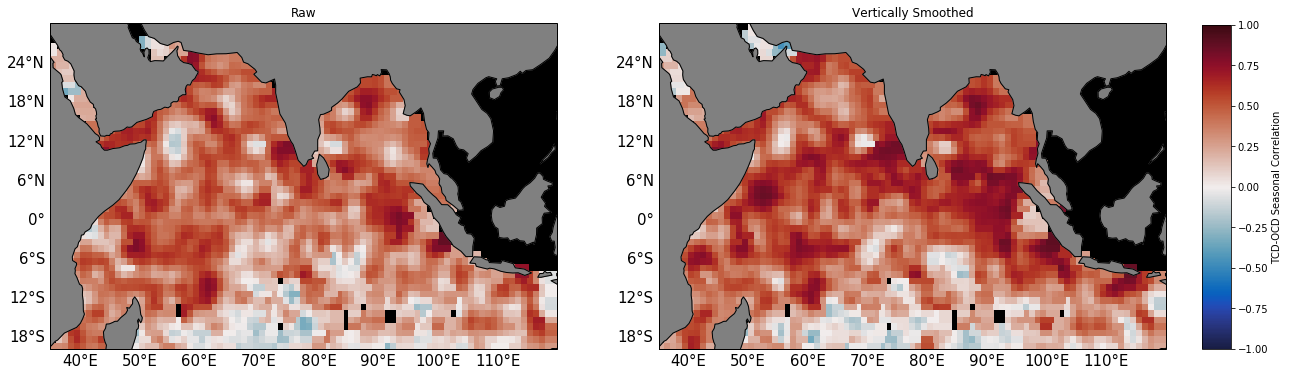

In [68]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins,ds_corr.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -1
cmax = 1
bounds = [35,120,-20,30]
s = 150
cmap = cmocean.cm.balance

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.r_value_filt_TCD_OCD.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Raw')

p2 = axes[1].scatter(xx,yy,c = ds_corr.r_value_sm_10_filt_TCD_OCD.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1],bounds)
axes[1].set_title('Vertically Smoothed')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-OCD Seasonal Correlation')

## <font color='orange'>TCD and SLA</font> 

In [53]:
# TCD/SLA Binned Correlations
slope_TCD_SLA, intercept_TCD_SLA, r_value_TCD_SLA, p_value_TCD_SLA, std_err_TCD_SLA,latbins,lonbins = latlonbin_corr(ds_CD.TCD_AWG,
                                                                                                                               ds_SLA.daily_sla_dtrnd_AWG,
                                                                                                                               ds_CD.lat,
                                                                                                                               ds_CD.lon,
                                                                                                                               bounds,1)
slope_sm_10_TCD_SLA, intercept_sm_10_TCD_SLA, r_value_sm_10_TCD_SLA, p_value_sm_10_TCD_SLA, std_err_sm_10_TCD_SLA,_,_  = latlonbin_corr(ds_CD.TCD_sm_10_AWG,
                                                                                                                                        ds_SLA.daily_sla_dtrnd_AWG,
                                                                                                                                        ds_CD.lat,
                                                                                                                                        ds_CD.lon,
                                                                                                                                    bounds,1)

# add to dataset
ds_corr['r_value_TCD_SLA'] = xr.DataArray(np.array(r_value_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_TCD_SLA'] = xr.DataArray(np.array(slope_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_TCD_SLA'] = xr.DataArray(np.array(std_err_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_TCD_SLA'] = xr.DataArray(np.array(intercept_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_corr['r_value_sm_10_TCD_SLA'] = xr.DataArray(np.array(r_value_sm_10_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_TCD_SLA'] = xr.DataArray(np.array(slope_sm_10_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_TCD_SLA'] = xr.DataArray(np.array(std_err_sm_10_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_TCD_SLA'] = xr.DataArray(np.array(intercept_sm_10_TCD_SLA,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_sm_10_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_filt_TCD_SLA'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_SLA,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-

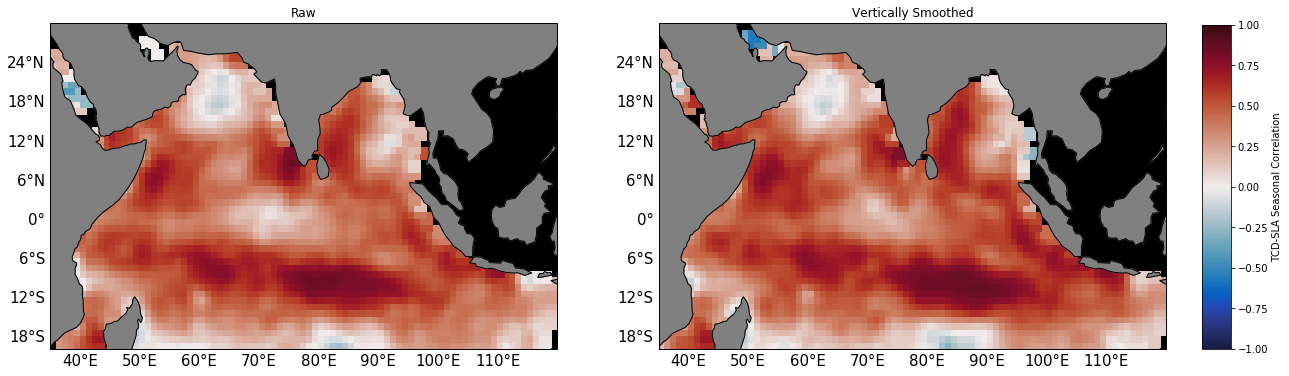

In [63]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins,ds_corr.latbins)
yy = yy.flatten()

# limits
cmin = -1
cmax = 1
bounds = [35,120,-20,30]
s = 150
cmap = cmocean.cm.balance

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.r_value_filt_TCD_SLA.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Raw')

p = axes[1].scatter(xx,yy,c = ds_corr.r_value_sm_10_filt_TCD_SLA.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-SLA Seasonal Correlation')

# <font color='darkblue'>Interannual Correlation</font> 

## <font color='orange'>TCD and OCD</font> 

In [65]:
bounds = [35,120,-20,30]

# TCD/OCD Binned
slope_TCD_OCD_anom, intercept_TCD_OCD_anom, r_value_TCD_OCD_anom, p_value_TCD_OCD_anom, std_err_TCD_OCD_anom,latbins,lonbins = latlonbin_corr(ds_CD.TCD_anom,
                                                                                                                               ds_CD.OCD_anom,
                                                                                                                               ds_CD.lat,
                                                                                                                               ds_CD.lon,
                                                                                                                               bounds,1)
slope_sm_10_TCD_OCD_anom, intercept_sm_10_TCD_OCD_anom, r_value_sm_10_TCD_OCD_anom, p_value_sm_10_TCD_OCD_anom, std_err_sm_10_TCD_OCD_anom,_,_  = latlonbin_corr(ds_CD.TCD_sm_10_anom,
                                                                                                                                        ds_CD.OCD_sm_10_anom,
                                                                                                                                        ds_CD.lat,
                                                                                                                                        ds_CD.lon,
                                                                                                                                        bounds,1)

# add to dataset
ds_corr['r_value_TCD_OCD_anom'] = xr.DataArray(np.array(r_value_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_TCD_OCD_anom'] = xr.DataArray(np.array(slope_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_TCD_OCD_anom'] = xr.DataArray(np.array(std_err_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_TCD_OCD_anom'] = xr.DataArray(np.array(intercept_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_corr['r_value_sm_10_TCD_OCD_anom'] = xr.DataArray(np.array(r_value_sm_10_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_TCD_OCD_anom'] = xr.DataArray(np.array(slope_sm_10_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_TCD_OCD_anom'] = xr.DataArray(np.array(std_err_sm_10_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_TCD_OCD_anom'] = xr.DataArray(np.array(intercept_sm_10_TCD_OCD_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_sm_10_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_filt_TCD_OCD_anom'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_OCD_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/si

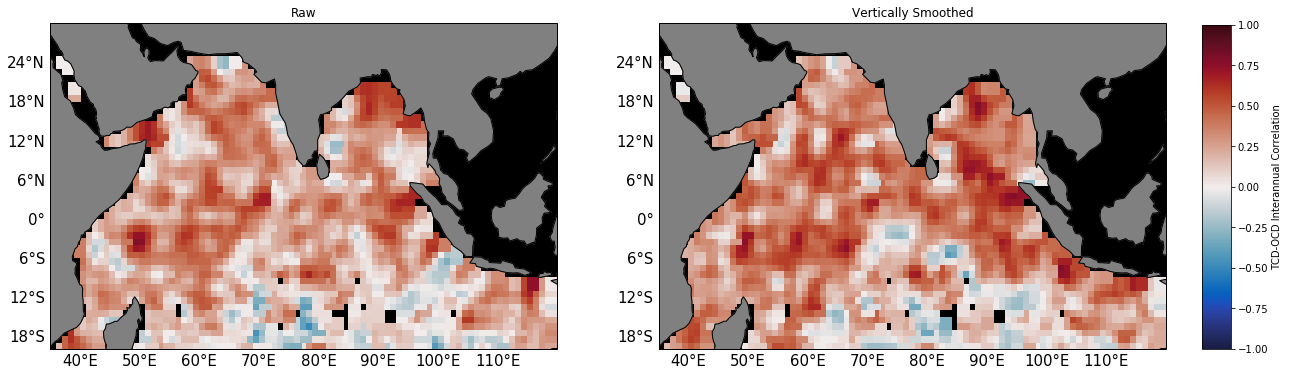

In [66]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins,ds_corr.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -1
cmax = 1
bounds = [35,120,-20,30]
s = 150
cmap = cmocean.cm.balance

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.r_value_filt_TCD_OCD_anom.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Raw')

p2 = axes[1].scatter(xx,yy,c = ds_corr.r_value_sm_10_filt_TCD_OCD_anom.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-OCD Interannual Correlation')

## <font color='orange'>TCD and SLA</font> 

In [69]:
# TCD/SLA Binned Correlations
slope_TCD_SLA_anom, intercept_TCD_SLA_anom, r_value_TCD_SLA_anom, p_value_TCD_SLA_anom, std_err_TCD_SLA_anom,latbins,lonbins = latlonbin_corr(ds_CD.TCD_anom,
                                                                                                                               ds_SLA.daily_sla_dtrnd_AWG,
                                                                                                                               ds_CD.lat,
                                                                                                                               ds_CD.lon,
                                                                                                                               bounds,1)
slope_sm_10_TCD_SLA_anom, intercept_sm_10_TCD_SLA_anom, r_value_sm_10_TCD_SLA_anom, p_value_sm_10_TCD_SLA_anom, std_err_sm_10_TCD_SLA_anom,_,_  = latlonbin_corr(ds_CD.TCD_sm_10_anom,
                                                                                                                                        ds_SLA.daily_sla_dtrnd_AWG,
                                                                                                                                        ds_CD.lat,
                                                                                                                                        ds_CD.lon,
                                                                                                                                        bounds,1)

# add to dataset
ds_corr['r_value_TCD_SLA_anom'] = xr.DataArray(np.array(r_value_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_TCD_SLA_anom'] = xr.DataArray(np.array(slope_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_TCD_SLA_anom'] = xr.DataArray(np.array(std_err_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_TCD_SLA_anom'] = xr.DataArray(np.array(intercept_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_corr['r_value_sm_10_TCD_SLA_anom'] = xr.DataArray(np.array(r_value_sm_10_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_TCD_SLA_anom'] = xr.DataArray(np.array(slope_sm_10_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_TCD_SLA_anom'] = xr.DataArray(np.array(std_err_sm_10_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_TCD_SLA_anom'] = xr.DataArray(np.array(intercept_sm_10_TCD_SLA_anom,dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['r_value_sm_10_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['slope_sm_10_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['std_err_sm_10_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_corr['intercept_sm_10_filt_TCD_SLA_anom'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_SLA_anom,1),dtype = float),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/jennap/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/jennap/anaconda3/lib/python3.7/site-

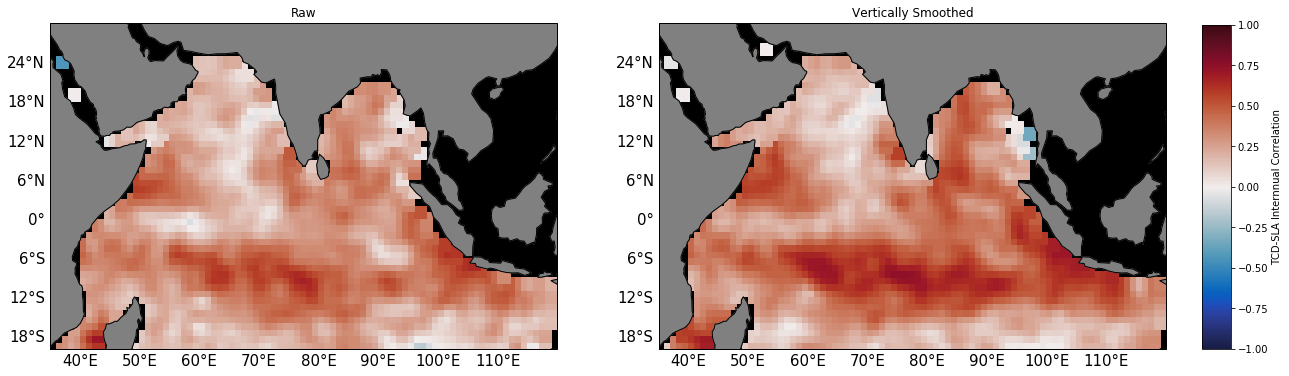

In [71]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins,ds_corr.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -1
cmax = 1
bounds = [35,120,-20,30]
s = 150
cmap = cmocean.cm.balance

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.r_value_filt_TCD_SLA_anom.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Raw')

p = axes[1].scatter(xx,yy,c = ds_corr.r_value_sm_10_filt_TCD_SLA_anom.stack(z=('latbins','lonbins')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-SLA Internnual Correlation')

# end

## <font color='orange'>TCD and SLA Monthly Mean</font> 

In [ ]:
# monthly correlation for TCD and SLA --------------------------------------------------------------#
def latlonbin_corr_mon(var1,var2,lat,lon,time,bounds,binwidth):
    import numpy as np
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            time =  time,
            var1=np.array(var1),
            var2=np.array(var2),
            lat=np.array(lat),
            lon=np.array(lon),
        ))
    df = df.set_index('time')

    # set to nans all the values where there isn't a tcd and ocd value
    ind = (df['var1'].isnull()) | (df['var2'].isnull()) 
    df.loc[(ind),'var1']=np.nan
    df.loc[(ind),'var2']=np.nan

    # create bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)
    
    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    SLOPE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    INTERCEPT = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    R_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    P_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    STD_ERR = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        # find correlations if all in the group are not nans
        if ~group.var2.isnull().all():
            
            group_mon = group.resample('1MS').mean()
            
            # find monthly mean data of each bin
            var1_mon = group_mon.var1
            var2_mon = group_mon.var2
            
            nanmask = ~np.isnan(var1_mon) & ~np.isnan(var2_mon)
            slope, intercept, r_value, p_value, std_err=stats.linregress(var2_mon[nanmask],var1_mon[nanmask])
            
            SLOPE[i[0],j[0]] = slope
            INTERCEPT[i[0],j[0]] = intercept
            R_VALUE[i[0],j[0]] = r_value
            P_VALUE[i[0],j[0]] = p_value
            STD_ERR[i[0],j[0]] = std_err

    return(np.array(SLOPE,dtype = float),np.array(INTERCEPT,dtype = float),np.array(R_VALUE,dtype = float), 
           np.array(P_VALUE,dtype = float),np.array(STD_ERR,dtype = float),latbins,lonbins)



# TCD/OCD Binned
slope_TCD_SLA_mon, intercept_TCD_SLA_mon, r_value_TCD_SLA_mon, p_value_TCD_SLA_mon, std_err_TCD_SLA_mon,latbins_2deg,lonbins_2deg = latlonbin_corr_mon(ds_AWG.TCD,ds_SLA.daily_sla_dtrnd_AWG,ds_AWG.lat,ds_AWG.lon,ds_AWG.time,bounds,2)
slope_sm_10_TCD_SLA_mon, intercept_sm_10_TCD_SLA_mon, r_value_sm_10_TCD_SLA_mon, p_value_sm_10_TCD_SLA_mon, std_err_sm_10_TCD_SLA_mon,_,_  = latlonbin_corr_mon(ds_AWG.TCD_sm_10,ds_SLA.daily_sla_dtrnd_AWG,ds_AWG.lat,ds_AWG.lon,ds_AWG.time,bounds,2)

# add to dataset
ds_corr['r_value_TCD_SLA_mon'] = xr.DataArray(np.array(r_value_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_TCD_SLA_mon'] = xr.DataArray(np.array(slope_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_TCD_SLA_mon'] = xr.DataArray(np.array(std_err_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_TCD_SLA_mon'] = xr.DataArray(np.array(intercept_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['r_value_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

ds_corr['r_value_sm_10_TCD_SLA_mon'] = xr.DataArray(np.array(r_value_sm_10_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_sm_10_TCD_SLA_mon'] = xr.DataArray(np.array(slope_sm_10_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_sm_10_TCD_SLA_mon'] = xr.DataArray(np.array(std_err_sm_10_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_sm_10_TCD_SLA_mon'] = xr.DataArray(np.array(intercept_sm_10_TCD_SLA_mon,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['r_value_sm_10_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_sm_10_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_sm_10_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_sm_10_filt_TCD_SLA_mon'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_SLA_mon,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

In [ ]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins_2deg,ds_corr.latbins_2deg)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 0
cmax = 500
bounds = [35,120,-20,30]
s = 150
cmap = plt.cm.Spectral_r # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.slope_filt_TCD_SLA_mon.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[0].contour(ds_corr.lonbins_2deg,ds_corr.latbins_2deg,ds_corr.r_value_filt_TCD_SLA_mon,levels = np.arange(-1,1,0.2), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Regression Slope and R-value')

p2 = axes[1].scatter(xx,yy,c = ds_corr.slope_sm_10_filt_TCD_SLA_mon.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[1].contour(ds_corr.lonbins_2deg,ds_corr.latbins_2deg,ds_corr.r_value_sm_10_filt_TCD_SLA_mon,levels = np.arange(-1,1,0.2), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Regression Slope and R-value Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-SLA Regression Slope')

## <font color='orange'>TCD and SLA Seasonal Mean</font> 

In [ ]:
# monthly correlation for TCD and SLA --------------------------------------------------------------#
def latlonbin_corr_seas(var1,var2,lat,lon,time,bounds,binwidth):
    import numpy as np
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            time =  time,
            var1=np.array(var1),
            var2=np.array(var2),
            lat=np.array(lat),
            lon=np.array(lon),
        ))
    df = df.set_index('time')

    # set to nans all the values where there isn't a tcd and ocd value
    ind = (df['var1'].isnull()) | (df['var2'].isnull()) 
    df.loc[(ind),'var1']=np.nan
    df.loc[(ind),'var2']=np.nan

    # create bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)
    
    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    SLOPE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    INTERCEPT = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    R_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    P_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    STD_ERR = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        # find correlations if all in the group are not nans
        if ~group.var2.isnull().all():
            
            group_mon = group.resample('QS-DEC').mean()
            
            # find monthly mean data of each bin
            var1_mon = group_mon.var1
            var2_mon = group_mon.var2
            
            nanmask = ~np.isnan(var1_mon) & ~np.isnan(var2_mon)
            slope, intercept, r_value, p_value, std_err=stats.linregress(var2_mon[nanmask],var1_mon[nanmask])
            
            SLOPE[i[0],j[0]] = slope
            INTERCEPT[i[0],j[0]] = intercept
            R_VALUE[i[0],j[0]] = r_value
            P_VALUE[i[0],j[0]] = p_value
            STD_ERR[i[0],j[0]] = std_err

    return(np.array(SLOPE,dtype = float),np.array(INTERCEPT,dtype = float),np.array(R_VALUE,dtype = float), 
           np.array(P_VALUE,dtype = float),np.array(STD_ERR,dtype = float),latbins,lonbins)



# TCD/OCD Binned
slope_TCD_SLA_seas, intercept_TCD_SLA_seas, r_value_TCD_SLA_seas, p_value_TCD_SLA_seas, std_err_TCD_SLA_seas,latbins_2deg,lonbins_2deg = latlonbin_corr_mon(ds_AWG.TCD,ds_SLA.daily_sla_dtrnd_AWG,ds_AWG.lat,ds_AWG.lon,ds_AWG.time,bounds,2)
slope_sm_10_TCD_SLA_seas, intercept_sm_10_TCD_SLA_seas, r_value_sm_10_TCD_SLA_seas, p_value_sm_10_TCD_SLA_seas, std_err_sm_10_TCD_SLA_seas,_,_  = latlonbin_corr_mon(ds_AWG.TCD_sm_10,ds_SLA.daily_sla_dtrnd_AWG,ds_AWG.lat,ds_AWG.lon,ds_AWG.time,bounds,2)

# add to dataset
ds_corr['r_value_TCD_SLA_seas'] = xr.DataArray(np.array(r_value_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_TCD_SLA_seas'] = xr.DataArray(np.array(slope_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_TCD_SLA_seas'] = xr.DataArray(np.array(std_err_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_TCD_SLA_seas'] = xr.DataArray(np.array(intercept_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['r_value_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(r_value_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(slope_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(std_err_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(intercept_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

ds_corr['r_value_sm_10_TCD_SLA_seas'] = xr.DataArray(np.array(r_value_sm_10_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_sm_10_TCD_SLA_seas'] = xr.DataArray(np.array(slope_sm_10_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_sm_10_TCD_SLA_seas'] = xr.DataArray(np.array(std_err_sm_10_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_sm_10_TCD_SLA_seas'] = xr.DataArray(np.array(intercept_sm_10_TCD_SLA_seas,dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['r_value_sm_10_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['slope_sm_10_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['std_err_sm_10_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
ds_corr['intercept_sm_10_filt_TCD_SLA_seas'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10_TCD_SLA_seas,1),dtype = float),
                                   dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

In [ ]:
# Plotting

xx,yy = np.meshgrid(ds_corr.lonbins_2deg,ds_corr.latbins_2deg)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 0
cmax = 500
bounds = [35,120,-20,30]
s = 150
cmap = plt.cm.Spectral_r # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_corr.slope_filt_TCD_SLA_seas.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[0].contour(ds_corr.lonbins_2deg,ds_corr.latbins_2deg,ds_corr.r_value_filt_TCD_SLA_seas,levels = np.arange(-1,1,0.2), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Regression Slope and R-value')

p2 = axes[1].scatter(xx,yy,c = ds_corr.slope_sm_10_filt_TCD_SLA_seas.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[1].contour(ds_corr.lonbins_2deg,ds_corr.latbins_2deg,ds_corr.r_value_sm_10_filt_TCD_SLA_seas,levels = np.arange(-1,1,0.2), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Regression Slope and R-value Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-SLA Regression Slope')

In [ ]:
# import numpy as np
# # create a pandas dataframe
# df = pd.DataFrame(dict(
#         var1=np.array(var1),
#         var2=np.array(var2),
#         lat=np.array(lat),
#         lon=np.array(lon),
#     ))

# # set to nans all the values where there isn't a tcd and ocd value
# ind = (df['var1'].isnull()) | (df['var2'].isnull()) 
# df.loc[(ind),'var1']=np.nan
# df.loc[(ind),'var2']=np.nan

# # create bins
# latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
# lat_inds = list(range(len(latedges)-1))

# lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
# lon_inds = list(range(len(lonedges)-1))

# latbins = latedges[1:]-(binwidth/2)
# lonbins = lonedges[1:]-(binwidth/2)

# df['latedges'] = pd.cut(lat, latedges)
# df['lonedges'] = pd.cut(lon, lonedges)
# df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
# df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
# df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
# grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

# SLOPE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
# INTERCEPT = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
# R_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
# P_VALUE = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
# STD_ERR = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

# #extract the data for each group
# for name, group in grouped:
#     i = np.array(group.latbins_ind)
#     j = np.array(group.lonbins_ind)

#     # find correlations if all in the group are not nans
#     if ~group.var2.isnull().all():

#         # find monthly mean data of each bin
#         var1_mon = group.var1.resample(time='1MS').mean(dim="time")
#         var2_mon = group.var2.resample(time='1MS').mean(dim="time")

#         nanmask = ~np.isnan(var1_mon) & ~np.isnan(var2_mon)
#         slope, intercept, r_value, p_value, std_err=stats.linregress(var2_mon[nanmask],var1_mon[nanmask])

#         SLOPE[i[0],j[0]] = slope
#         INTERCEPT[i[0],j[0]] = intercept
#         R_VALUE[i[0],j[0]] = r_value
#         P_VALUE[i[0],j[0]] = p_value
#         STD_ERR[i[0],j[0]] = std_err

#     return(np.array(SLOPE,dtype = float),np.array(INTERCEPT,dtype = float),np.array(R_VALUE,dtype = float), 
#            np.array(P_VALUE,dtype = float),np.array(STD_ERR,dtype = float),latbins,lonbins)

## <font color='orange'>TCD and SLA</font> 

In [ ]:
# TCD/OCD Binned
slope, intercept, r_value, p_value, std_err,latbins_2deg,lonbins_2deg = latlonbin_corr(ds_AWG.TCD_time_sorted,
                                                                                       ds_AWG.OCD,ds_AWG.lat_sorted,
                                                                                       ds_AWG.lon_sorted,bounds,2)
# slope_sm_10, intercept_sm_10, r_value_sm_10, p_value_sm_10, std_err_sm_10,_,_  = latlonbin_corr(ds_AWG.TCD_sm_10,ds_AWG.OCD_sm_10,ds_AWG.lat,ds_AWG.lon,bounds,2)

# # add to dataset
# ds_AWG['r_value'] = xr.DataArray(np.array(r_value,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['slope'] = xr.DataArray(np.array(slope,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['std_err'] = xr.DataArray(np.array(std_err,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['intercept'] = xr.DataArray(np.array(intercept,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['r_value_filt'] = xr.DataArray(np.array(gaus_filter_nan(r_value,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['slope_filt'] = xr.DataArray(np.array(gaus_filter_nan(slope,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['std_err_filt'] = xr.DataArray(np.array(gaus_filter_nan(std_err,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['intercept_filt'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

# ds_AWG['r_value_sm_10'] = xr.DataArray(np.array(r_value_sm_10,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['slope_sm_10'] = xr.DataArray(np.array(slope_sm_10,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['std_err_sm_10'] = xr.DataArray(np.array(std_err_sm_10,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['intercept_sm_10'] = xr.DataArray(np.array(intercept_sm_10,dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['r_value_sm_10_filt'] = xr.DataArray(np.array(gaus_filter_nan(r_value_sm_10,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['slope_sm_10_filt'] = xr.DataArray(np.array(gaus_filter_nan(slope_sm_10,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['std_err_sm_10_filt'] = xr.DataArray(np.array(gaus_filter_nan(std_err_sm_10,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])
# ds_AWG['intercept_sm_10_filt'] = xr.DataArray(np.array(gaus_filter_nan(intercept_sm_10,1),dtype = float),
#                                    dims = ['latbins_2deg','lonbins_2deg'],coords =[latbins_2deg,lonbins_2deg])

In [ ]:
cmin = 0
cmax = 2
bounds = [35,120,-20,30]
s = 150
cmap = plt.cm.Spectral_r # plt.cm.PuOr
plt.scatter(xx,yy,c = np.array(gaus_filter_nan(slope,1),dtype = float).stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax)

In [ ]:
# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins_2deg,ds_AWG.latbins_2deg)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 0
cmax = 2
bounds = [35,120,-20,30]
s = 150
cmap = plt.cm.Spectral_r # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,6),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0].scatter(xx,yy,c = ds_AWG.slope_filt.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[0].contour(ds_AWG.lonbins_2deg,ds_AWG.latbins_2deg,ds_AWG.r_value_filt,levels = np.arange(-1,1,0.1), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[0],bounds)
axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0].set_title('Regression Slope and R-value')

p2 = axes[1].scatter(xx,yy,c = ds_AWG.slope_sm_10_filt.stack(z=('latbins_2deg','lonbins_2deg')),marker='s',
                      s=s,cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ctr = axes[1].contour(ds_AWG.lonbins_2deg,ds_AWG.latbins_2deg,ds_AWG.r_value_sm_10_filt,levels = np.arange(-1,1,0.1), 
            colors = 'k',linestyles = 'dashed')
plt.clabel(ctr, inline=1, fontsize=10)
add_land(axes[1],bounds)
axes[1].set_title('Regression Slope and R-value Vertically Smoothed')



cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('TCD-OCD Regression Slope')

# Interannual Correlation

In [ ]:
def latlonbin_corr(TCD,OCD,lat,lon,date,binwidth):
    import numpy as np
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            TCD=np.array(TCD),
            OCD=np.array(OCD),
            TCD_masked=np.array(TCD),
            OCD_masked=np.array(OCD),
            lat=np.array(lat),
            lon=np.array(lon),
            date = ds.time,
            prof = np.array(ds.prof)
        ))

    # set to nans all the values where there isn't a tcd and ocd value
    ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
    df.loc[(ind),'TCD_masked']=np.nan
    df.loc[(ind),'OCD_masked']=np.nan

    # create 1 degree bins
    latedges = np.arange(lat.min()-(binwidth/2),lat.max()+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(lon.min()-(binwidth/2),lon.max()+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(ds.lat, latedges)
    df['lonedges'] = pd.cut(ds.lon, lonedges)
    df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    corr = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    slope = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan
    std_err = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)*np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        # find correlations if all in the group are not nans
        if ~group.OCD_masked.isnull().all():
            TCDanom = group.TCD_masked - np.nanmean(group.TCD_masked)
            OCDanom = group.OCD_masked - np.nanmean(group.OCD_masked)
            nanmask = ~np.isnan(TCDanom) & ~np.isnan(OCDanom)
            reg_slope, intercept, r_value, p_value, stderr=stats.linregress(OCDanom[nanmask],
                                                                            TCDanom[nanmask])
            corr[i[0],j[0]] = r_value
            slope[i[0],j[0]] = reg_slope
            std_err[i[0],j[0]] = stderr

    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

    return(np.array(corr,dtype = float), np.array(slope,dtype = float),
           np.array(std_err,dtype = float),lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)

# TCD/OCD Binned
corr,slope,std_err, lonbins, latbins,lonp,latp = latlonbin_corr(ds.TCD,ds.OCD,ds.lat,ds.lon,ds.time,2)

# min_TCD_month_sm_10, min_OCD_month_sm_10, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
   
# min_TCD_month_sm_10_filt = gaus_filter_nan(min_TCD_month_sm_10,1)
# min_OCD_month_sm_10_filt = gaus_filter_nan(min_OCD_month_sm_10,1)
    
# figure out why it isn't saving correctly to the ds!
    
# ds['min_OCD'] = xr.DataArray(np.array(min_OCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month'] = xr.DataArray(min_OCD_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])


# ds['min_TCD'] = xr.DataArray(np.array(min_TCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_TCD_month'] = xr.DataArray(np.array(min_TCD_month,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # add to dataset
# ds['min_TCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_TCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_OCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
import cmocean
plt.pcolormesh(lonbins,latbins,corr,cmap=cmocean.cm.balance)
plt.colorbar()

## Gaussian Filtering

In [ ]:
# add to dataset
corr_filt = gaus_filter_nan(corr,1)

plt.pcolormesh(lonbins,latbins,corr_filt,cmap=cmocean.cm.balance,vmin=-1,vmax=1)
plt.colorbar()

# Months of lowest TCD and OCD with O and T vals

In [ ]:
def latlonbin(TCD,OCD,lat,lon,date,binwidth):
    import numpy as np
    # find TCD anomaly and do correlatinos there.
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            TCD=np.array(TCD),
            OCD=np.array(OCD),
            TCD_masked=np.array(TCD),
            OCD_masked=np.array(OCD),
            lat=np.array(lat),
            lon=np.array(lon),
            date = ds.time,
            prof = np.array(ds.prof)
        ))

    # add in a column for the month
    df['month'] = pd.DatetimeIndex(df['date']).month

    # set to nans all the values where there isn't a tcd and ocd value

    ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
    df.loc[(ind),'TCD_masked']=np.nan
    df.loc[(ind),'OCD_masked']=np.nan

    # create 1 degree bins
    binwidth = 1
    # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
    latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
    lat_inds = list(range(len(latedges)-1))

    # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
    lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(ds.lat, latedges)
    df['lonedges'] = pd.cut(ds.lon, lonedges)
    df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])


    min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD[:] = np.nan

    min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD_month[:] = np.nan

    min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD[:] = np.nan

    min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD_month[:] = np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        month = np.array(group.month)


        # find month of minimum OCD
        if ~np.isnan(np.nanmin(group.OCD_masked)):
            min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
            ind = np.nanargmin(group.OCD_masked)
            min_OCD_month[i[0],j[0]] = month[ind]
        if ~np.isnan(np.nanmin(group.TCD_masked)): 
            min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
            ind = np.nanargmin(group.TCD_masked)
            min_TCD_month[i[0],j[0]] = month[ind]
            
    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

    return(np.array(min_TCD_month,dtype = float), np.array(min_OCD_month,dtype = float),
           lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)

# TCD/OCD Binned
min_TCD_month, min_OCD_month, lonbins, latbins,lonp,latp = latlonbin(ds.TCD,ds.OCD,ds.lat,ds.lon,ds.time,binwidth)

min_TCD_month_sm_10, min_OCD_month_sm_10, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
   
min_TCD_month_sm_10_filt = gaus_filter_nan(min_TCD_month_sm_10,1)
min_OCD_month_sm_10_filt = gaus_filter_nan(min_OCD_month_sm_10,1)
    
# figure out why it isn't saving correctly to the ds!
    
# ds['min_OCD'] = xr.DataArray(np.array(min_OCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month'] = xr.DataArray(min_OCD_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])


# ds['min_TCD'] = xr.DataArray(np.array(min_TCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_TCD_month'] = xr.DataArray(np.array(min_TCD_month,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # add to dataset
# ds['min_TCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_TCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_OCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# Plotting
import cmocean

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 20
cmax = 160
bounds = [35,100,0,30]
cmap = plt.cm.RdBu_r #cmocean.cm.phase

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,8),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,min_TCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Month of Minimum TCD')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,min_TCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,min_OCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Month of Minimum OCD')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,min_OCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('Month of Minimum OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04,
                    ticks = np.arange(1,13))
cbar.set_ticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

## Find Correlations


In [ ]:
# # my attempt without pandas
# import itertools

# binwidth = 1
# latedges =  list(np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth))
# lonedges =  list(np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth))

# TCD_BINNED = np.zeros((len(latedges),len(lonedges)), dtype=np.ndarray)

# for i in range(len(latedges)-1):
#     for j in range(len(lonedges)-1):
# #         print(i,j)
    
#         ind = (ds.lat>= latedges[i]) & (ds.lat<=latedges[i+1]) & (ds.lon>= lonedges[j]) & (ds.lon<=lonedges[j+1])
        
#         TCD_BINNED[i,j] = np.array(ds.TCD[ind])
#         TCD_binned_ave = np.nanmean(ds.TCD[ind])

# set values to nans for the correlations



In [ ]:
# # convert to np array to work with the stats.binned stuff.
# lon = np.array(ds.lon)
# lat = np.array(ds.lat)

# # create 1 degree bins
# latedges = np.r_[ds.lat.min():ds.lat.max():1]
# lonedges = np.r_[ds.lon.min():ds.lon.max():1]

# TCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD)], 
#                                                                  lon[~np.isnan(TCD)], TCD[~np.isnan(TCD)], 
#                                                                  'mean', bins=[latedges, lonedges])
# OCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD)], 
#                                                                  lon[~np.isnan(OCD)], OCD[~np.isnan(OCD)], 
#                                                                  'mean', bins=[latedges, lonedges])

# TCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD_sm_10)], 
#                                                                  lon[~np.isnan(TCD_sm_10)], 
#                                                                  TCD_sm_10[~np.isnan(TCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# OCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD_sm_10)], 
#                                                                  lon[~np.isnan(OCD_sm_10)], 
#                                                                  OCD_sm_10[~np.isnan(OCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# lonbins = xedges[1:] - 1/2
# latbins = yedges[1:] - 1/2

# # add to dataset
# ds['lonbins'] = xr.DataArray(lonbins,dims = ['lonbins'],coords =[lonbins])
# ds['latbins'] = xr.DataArray(latbins,dims = ['latbins'],coords =[latbins])

# ds['TCD_binned'] = xr.DataArray(TCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_binned'] = xr.DataArray(OCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['TCD_sm_10_binned'] = xr.DataArray(TCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned'] = xr.DataArray(OCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # apply a Guassian filter with st = 1 --- figure out how to deal with the coastlines later
# TCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.TCD_sm_10_binned,
#                                                          sigma=1),coords = [ds.latbins,ds.lonbins])

# OCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.OCD_sm_10_binned,
#                                                        sigma=1),coords = [ds.latbins,ds.lonbins])
# # add to dataset
# ds['TCD_sm_10_binned_filtered'] = xr.DataArray(TCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned_filtered'] = xr.DataArray(OCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# # find TCD anomaly and do correlatinos there.
# # create a pandas dataframe
# df = pd.DataFrame(dict(
#         TCD=np.array(ds.TCD),
#         OCD=np.array(ds.OCD),
#         TCD_masked=np.array(ds.TCD),
#         OCD_masked=np.array(ds.OCD),
#         lat=np.array(ds.lat),
#         lon=np.array(ds.lon),
#         date = ds.time,
#         prof = np.array(ds.prof)
#     ))

# # add in a column for the month
# df['month'] = pd.DatetimeIndex(df['date']).month

# # set to nans all the values where there isn't a tcd and ocd value

# ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
# df.loc[(ind),'TCD_masked']=np.nan
# df.loc[(ind),'OCD_masked']=np.nan

# # create 1 degree bins
# binwidth = 1
# # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
# latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
# lat_inds = list(range(len(latedges)-1))

# # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
# lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
# lon_inds = list(range(len(lonedges)-1))

# latbins = latedges[1:]-(binwidth/2)
# lonbins = lonedges[1:]-(binwidth/2)

# df['latedges'] = pd.cut(ds.lat, latedges)
# df['lonedges'] = pd.cut(ds.lon, lonedges)
# df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
# df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
# df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
# grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

# TCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_BINNED[:] = np.nan
# OCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_BINNED[:] = np.nan

# TCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_binned_ave[:] = np.nan

# OCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_binned_ave[:] = np.nan

# min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD[:] = np.nan

# min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD_month[:] = np.nan

# min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD[:] = np.nan

# min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD_month[:] = np.nan

# #extract the data for each group
# for name, group in grouped:
#     i = np.array(group.latbins_ind)
#     j = np.array(group.lonbins_ind)
#     month = np.array(group.month)
    
#     TCD_BINNED[i[0],j[0]] = group.TCD
#     OCD_BINNED[i[0],j[0]] = group.OCD
    
#     TCD_binned_ave[i[0],j[0]] = np.nanmean(group.TCD)
#     OCD_binned_ave[i[0],j[0]] = np.nanmean(group.OCD)
    
#     # find month of minimum OCD
#     if ~np.isnan(np.nanmin(group.OCD_masked)):
#         min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
#         ind = np.nanargmin(group.OCD_masked)
#         min_OCD_month[i[0],j[0]] = month[ind]
#     if ~np.isnan(np.nanmin(group.TCD_masked)): 
#         min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
#         ind = np.nanargmin(group.TCD_masked)
#         min_TCD_month[i[0],j[0]] = month[ind]
    
#     # find average doxy during month of minmum OCD
    
#     # seasonal correlations
#     # used masked variables
    
# #     scipy.stats.pearsonr(x, y)[source]¶
   